# Project Pipeline

Lucovica Schaerf, Antònio Mendes, Jaël Kortekaas

Large part of our code is used from: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Introduction

This file contains the the preprocessing pipeline to our project. 
As a first step we are importing the data and filtering out all the songs that
we don't need for our analysis. Secondly, we will implement the 'standard' 
pipeline and, once we obtain the most common words per each album, author, year
(...) we will move to another file to do the clustering and topic analysis.

## Import

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.collocations import *
from nltk.collocations import BigramAssocMeasures
import nltk
import re
import string
import gensim
import spacy
import itertools

from gensim import corpora, models
from nltk.corpus import wordnet as wn
from operator import itemgetter

import matplotlib.pyplot as plt

plot_dir = Path("./figures")
data_dir = Path("./data")

In [2]:
songs = []

with open('./data/lyrics.csv', 'r', encoding="utf-8") as infile:
    songs = pd.read_csv(infile)
    
print(songs.columns)

Index(['index', 'song', 'year', 'artist', 'genre', 'lyrics'], dtype='object')


In [3]:
artists = ['bruce-springsteen', 'elliot-smith', 'black-sabbath', 'deep-purple', 'david-bowie']

david_bowie = songs[songs[u'artist'] == 'david-bowie']
black_sabbath = songs[songs[u'artist'] == 'black-sabbath']
bruce_springsteen = songs[songs[u'artist'] == 'bruce-springsteen']
elliot_smith = songs[songs[u'artist'] == 'elliot-smith']
deep_purple = songs[songs[u'artist'] == 'deep-purple']

lyrics = pd.concat([david_bowie, black_sabbath, bruce_springsteen, elliot_smith, deep_purple], axis=0)
lyrics = lyrics.dropna()
lyrics

,index,song,year,artist,genre,lyrics
116793,116793,if-i-m-dreaming-my-life,2009,david-bowie,Rock,VERSE (there)\nWas she never there/here?\nWas ...
116794,116794,seven,2009,david-bowie,Rock,I forgot what my father said\nI forgot what he...
116795,116795,i-can-t-read,2009,david-bowie,Rock,I can't read and I can't write down\nI don't k...
116796,116796,thursday-s-child,2009,david-bowie,Rock,All of my life I've tried so hard\nDoing my be...
116797,116797,survive,2009,david-bowie,Rock,"Oh, my\nNaked eyes\nI should have kept you\nI ..."
116798,116798,i-dig-everything,2007,david-bowie,Rock,I've got the village I love - dig everything\n...
116799,116799,ian-fish-u-k-heir,2007,david-bowie,Rock,Instrumental
116800,116800,up-the-hill-backwards-1999-digital-remaster,2007,david-bowie,Rock,The vacuum created by the arrival of freedom\n...
116801,116801,good-morning-girl,2007,david-bowie,Rock,"Hey, hey, good morning girl\nHey, hey, good mo..."
116802,116802,segue-ramona-a-stone,2007,david-bowie,Rock,I was Ramona A Stone\nI started with no enemie...


## Processing Pipeline

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['oh', 'yeah', 'hey', 'doo', 'oo', 'uh', 'la', 'verse', 'chorus', 'bridge', 'x2', "'m", 'da', 'ooh', 'aaaahh', 'ooo', 'duh', 'whop', 'u', 'ah', 'na', 'whoa', 'ai', "n't", 'wa', 'gon', "'ll", 'gon', "'d", "'re", "'ve", "'em", "'", 'ca', 'ha', 'wo', 'wir', 'wan', 'doe', 'well', 'sha', 'ya', 'ta', "'cause", "`"]) # filter out common meaningless words/sounds and words describing song structure

The preprocessing pipeline we decided to implement includes the following steps:
- filtering out stopwords, puntuation, sounds typical from songs
- lemmatizing
- adding the most common bigrams

In [5]:
wnl = WordNetLemmatizer()
bigram_measures = BigramAssocMeasures()

def convertTuple(tup): 
    str =  '_'.join(tup) 
    return str
  
def simple_preprocess(lyrics, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    lyricslist = [re.sub('\-', '', str(lyric)) for lyric in lyrics['lyrics'].tolist()] # take out all hyphens that often connect meaningless words/sounds to these stopwords can be filtered out later
    lyricslist = [re.sub('[\.\,\?,\!,\(,\),\:,\",\[,\]]', '', str(lyric)) for lyric in lyricslist] # take out all punctuation
    lyricslist = [word_tokenize(lyric.lower()) for lyric in lyricslist]
    finder = []
    for i,lyric in enumerate(lyricslist):
        for j,token in enumerate(lyric):
            lyricslist[i][j] = wnl.lemmatize(str(token))
        lyricslist[i] = [word for word in lyric if word not in stop_words]
        finder.append(BigramCollocationFinder.from_words(lyric))
        finder[i] = finder[i].nbest(bigram_measures.pmi, 20)
        finder[i] = [convertTuple(x) for x in finder[i]] #need to append the two words back together
        lyricslist[i] = lyricslist[i] + finder[i]
    lyrics['bag_of_words'] = lyricslist


simple_preprocess(lyrics)
example = lyrics['bag_of_words'][116793]
example

['never',
 'there/here',
 'ever',
 'air',
 'breathed',
 'wrong',
 'time',
 'ohoh',
 'ohoh',
 'flower',
 'gallery',
 'hymn',
 'night',
 'singing',
 'come',
 'wrong',
 'time',
 'wrong',
 'day',
 'light',
 'fading',
 'dreaming',
 'life',
 'second',
 'time',
 'one',
 'living',
 'chance',
 'mother',
 'sigh',
 'father',
 'step',
 'aside',
 'wrong',
 'time',
 'ohoh',
 'ever',
 'ever',
 'dreaming',
 'life',
 'dreaming',
 'life',
 'away',
 'dreaming',
 'life',
 'dreaming',
 'dreaming',
 'dreaming',
 'dreaming',
 'life',
 'dreaming',
 'life',
 'away',
 'ohoh',
 'repeat',
 'dreaming',
 'life',
 'dreaming',
 'dreaming',
 'life',
 'away',
 'ohoh',
 'are_fading',
 'come_to',
 'fading_now',
 'father_step',
 'flower_so',
 'gallery_with',
 'hymn_of',
 'it_air',
 'just_one',
 'light_are',
 'living_chance',
 'mother_sigh',
 'never_there/here',
 'night_singing',
 'of_night',
 'one_living',
 'singing_come',
 'so_from',
 'step_aside',
 'to_me']

In [6]:
#count how many times a word appears --> give a document
#lyrics['bag_of_words']

list_BOWlyrics = [[]]
for lyric in lyrics['bag_of_words']:
    list_BOWlyrics += [lyric]

lyrics_dictionary = corpora.Dictionary(list_BOWlyrics)
print('Number of unique tokens:', len(lyrics_dictionary))

Number of unique tokens: 31161


In [7]:
print(dict(itertools.islice(lyrics_dictionary.token2id.items(), 12)))
print("word with id 8:", lyrics_dictionary[8])
print("frequency of token 8:", lyrics_dictionary.dfs[8])

{'air': 0, 'are_fading': 1, 'aside': 2, 'away': 3, 'breathed': 4, 'chance': 5, 'come': 6, 'come_to': 7, 'day': 8, 'dreaming': 9, 'ever': 10, 'fading': 11}
word with id 8: day
frequency of token 8: 415


In [8]:
# Filter out words that occur in less than 5 documents, or more than 70% of the documents.
lyrics_dictionary.filter_extremes(no_below=2, no_above=0.3)
print('Number of unique tokens:', len(lyrics_dictionary))

Number of unique tokens: 10555


In [9]:
# Bag-of-words representation of the documents
lyrics_bow_corpus = [lyrics_dictionary.doc2bow(d) for d in list_BOWlyrics]

In [10]:
# the BOW representation of the first document
print(lyrics_bow_corpus[1][:50])

[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 12), (9, 3), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 8), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 4)]


In [11]:
# which words (and how often) appear in the first document?
for i, freq in sorted(lyrics_bow_corpus[1], key=itemgetter(1), reverse=True)[:15]:
    print(lyrics_dictionary[i], "-->", freq)
print("...")

dreaming --> 12
life --> 8
wrong --> 4
away --> 3
ever --> 3
air --> 1
aside --> 1
breathed --> 1
chance --> 1
come --> 1
come_to --> 1
day --> 1
fading --> 1
father --> 1
flower --> 1
...


In [12]:
lyrics_ldamodel = models.ldamodel.LdaModel(lyrics_bow_corpus, num_topics=8, id2word = lyrics_dictionary, passes=25)

In [13]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
lyrics_ldamodel.show_topics(formatted=False, num_words=15)

[(0,
  [('take', 0.01618956),
   ('never', 0.014771292),
   ('little', 0.014334275),
   ('girl', 0.014103715),
   ('say', 0.010548905),
   ('let', 0.010482875),
   ('heart', 0.0101786265),
   ('go', 0.010070325),
   ('right', 0.008548915),
   ('baby', 0.008524567),
   ('get', 0.0071190023),
   ('come', 0.0068363887),
   ('feel', 0.0064001186),
   ('world', 0.006261827),
   ('thing', 0.006104602)]),
 (1,
  [('boy', 0.011079639),
   ('back', 0.010597329),
   ('go', 0.0068786405),
   ('alright', 0.006847258),
   ('tonight', 0.0064550736),
   ('little', 0.0059789554),
   ('young', 0.0058939336),
   ('town', 0.005403543),
   ('thing', 0.005141892),
   ('man', 0.0050711622),
   ('ho', 0.0048389668),
   ('come', 0.004629198),
   ('fall', 0.004567473),
   ('five', 0.004434078),
   ('sky', 0.0044302284)]),
 (2,
  [('come', 0.024778415),
   ('baby', 0.013563182),
   ('dance', 0.01209114),
   ('want', 0.011246827),
   ('dream', 0.010129356),
   ('man', 0.008270868),
   ('magic', 0.0076496154),
  

In [14]:
from collections import defaultdict

import nltk.corpus
import numpy as np
import matplotlib.pyplot as plt
import itertools

from gensim import corpora, models
from nltk.corpus import wordnet as wn
from operator import itemgetter

import sklearn
from sklearn import metrics, manifold
import scipy
from scipy import cluster
import matplotlib as mpl 
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D


In [15]:
print(list_BOWlyrics)

[[], ['never', 'there/here', 'ever', 'air', 'breathed', 'wrong', 'time', 'ohoh', 'ohoh', 'flower', 'gallery', 'hymn', 'night', 'singing', 'come', 'wrong', 'time', 'wrong', 'day', 'light', 'fading', 'dreaming', 'life', 'second', 'time', 'one', 'living', 'chance', 'mother', 'sigh', 'father', 'step', 'aside', 'wrong', 'time', 'ohoh', 'ever', 'ever', 'dreaming', 'life', 'dreaming', 'life', 'away', 'dreaming', 'life', 'dreaming', 'dreaming', 'dreaming', 'dreaming', 'life', 'dreaming', 'life', 'away', 'ohoh', 'repeat', 'dreaming', 'life', 'dreaming', 'dreaming', 'life', 'away', 'ohoh', 'are_fading', 'come_to', 'fading_now', 'father_step', 'flower_so', 'gallery_with', 'hymn_of', 'it_air', 'just_one', 'light_are', 'living_chance', 'mother_sigh', 'never_there/here', 'night_singing', 'of_night', 'one_living', 'singing_come', 'so_from', 'step_aside', 'to_me'], ['forgot', 'father', 'said', 'forgot', 'said', 'forgot', 'mother', 'said', 'lay', 'upon', 'bed', 'city', 'full', 'flower', 'city', 'full',

In [16]:
song_titles = lyrics["song"].values
print(song_titles)
print(len(song_titles))
bowie_song_titles = lyrics.query("artist == 'david-bowie'")["song"].values[:50]
print(bowie_song_titles)
print(len(bowie_song_titles))

doc2topics = np.zeros((len(bowie_song_titles), lyrics_ldamodel.num_topics))
#print(lyrics_ldamodel.num_topics)
#print(len(docs_id))
for di, doc_topics in enumerate(lyrics_ldamodel.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    #print(di)
    if(di >= len(bowie_song_titles)):
        break
    for ti, v in doc_topics:

        doc2topics[di, ti] = v

['if-i-m-dreaming-my-life' 'seven' 'i-can-t-read' ... 'paint-it-black'
 'anyone-s-daughter' 'perfect-strangers']
1551
['if-i-m-dreaming-my-life' 'seven' 'i-can-t-read' 'thursday-s-child'
 'survive' 'i-dig-everything' 'ian-fish-u-k-heir'
 'up-the-hill-backwards-1999-digital-remaster' 'good-morning-girl'
 'segue-ramona-a-stone' 'when-the-wind-blows-remastered' 'fly'
 'maguc-dance' 'day-in-day-out-single-version'
 'modern-love-single-version' 'heroes-english' 'did-you-ever-have-a-dream'
 'heroes-helden' 'and-i-say-to-myself' 'no-one-calls'
 'do-anything-you-say' 'scary-monsters-and-super-creeps-single-version'
 'underground-single-version' 'let-s-dance-single-version' 'sweet-jane'
 'cat-people-putting-out-fire-single-version' 'life-is-a-circus'
 'major-tom' 'i-m-not-losing-sleep' 'china-girl-single-version'
 'over-the-wall-we-go-oscar-version' 'ashes-to-ashes-single-version'
 'under-pressure-rah-mix' 'can-t-help-thinking-about-me'
 'amlapura-indomesian-version' 'fashion-single-version'
 '

In [50]:
print(lyrics_ldamodel.num_topics)
#print(((1-2) >= 0) * 2)

import random

the_list = [20, 16, 10, 5];
print(random.shuffle(the_list))

8
None


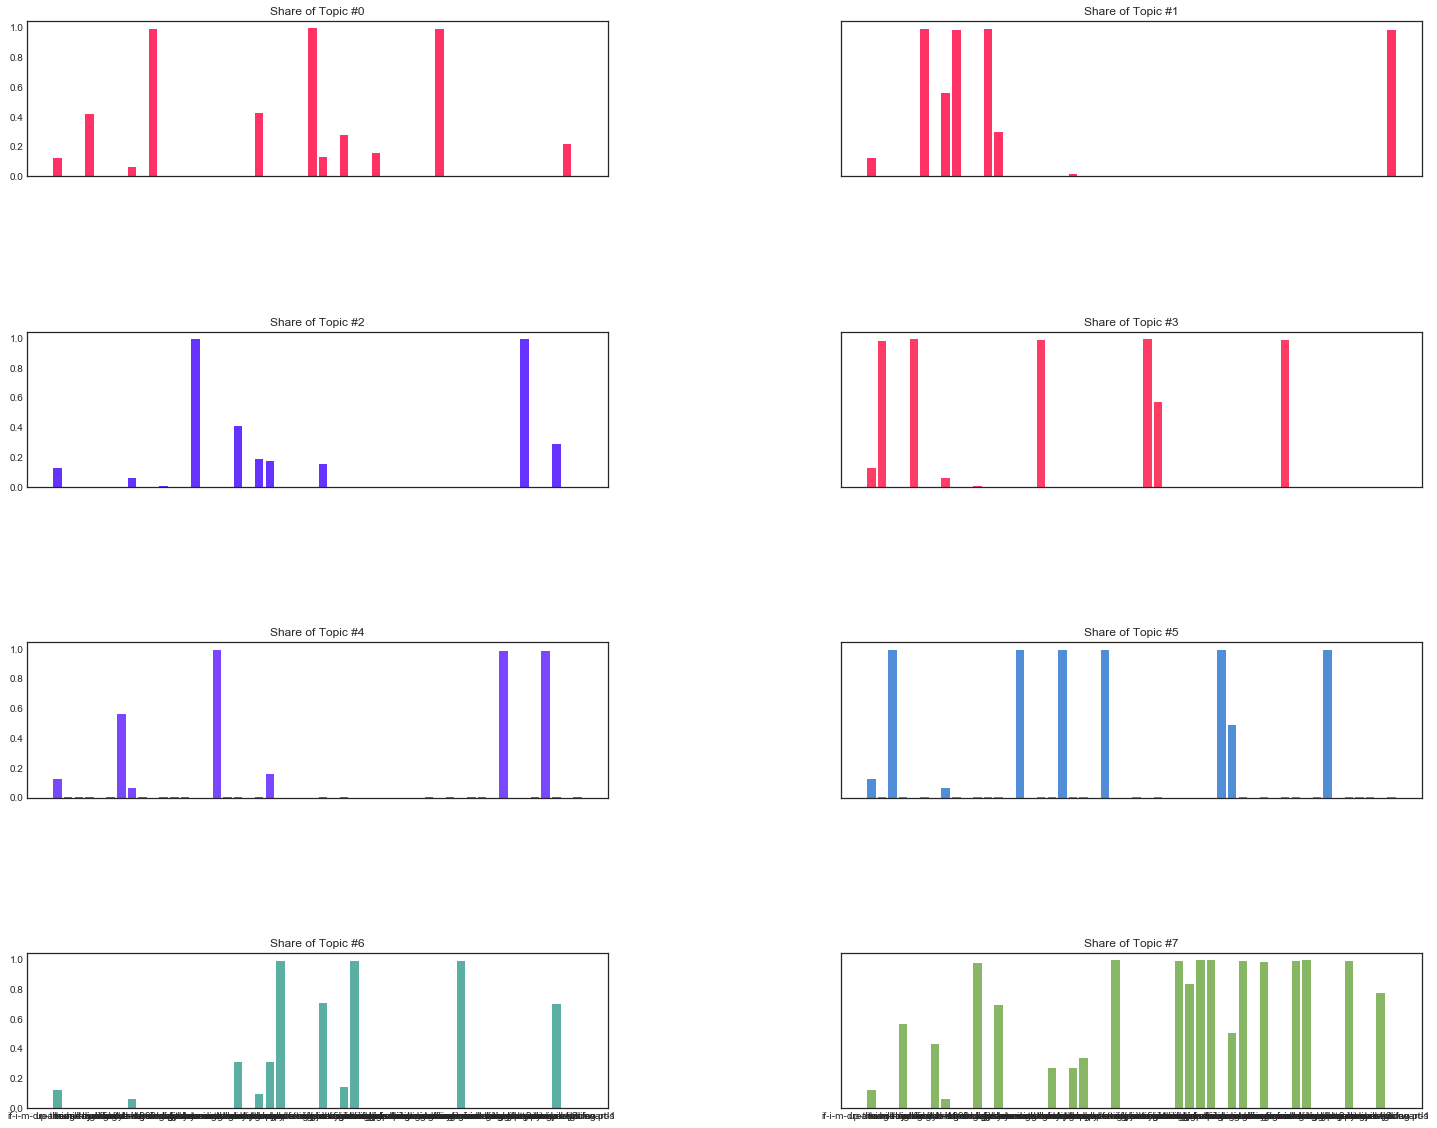

In [62]:
import math
import random

rows = math.ceil(lyrics_ldamodel.num_topics/2)

fig, ax = plt.subplots(rows, 2, sharex='col', sharey='row')
fig.subplots_adjust(hspace=1, wspace=0.4) 
fig.set_figheight(20)
fig.set_figwidth(25)

plt.setp(ax, xticks=ind, xticklabels=bowie_song_titles)

min_rgb = 100
jump = 10
colors = []
for i in range(lyrics_ldamodel.num_topics):
    r = round((255 - (((i - 4) >= 0) * 40 * (i - 4)))/255, 3)
    g = round((102 + (((i - 3) >= 0) * 20 * (i - 3)))/255, 3)
    b = round((50 + (((i - 2) >= 0) * 10 * (i - 2)))/255, 3)
    rgb = [r,g,b]
    
    colors.append(sorted(rgb, key=lambda k: random.random()))

ind = range(len(bowie_song_titles))
which_topic = 0
for i in range(rows):
    for j in range(2):
        if(which_topic == (lyrics_ldamodel.num_topics - (lyrics_ldamodel.num_topics % 2))):
            break
        
        ax[i,j].bar(ind, doc2topics[:,which_topic], color = colors[which_topic])
        
        ax[i,j].title.set_text('Share of Topic #%d'%which_topic)

        
        which_topic += 1   

0
0


IndexError: too many indices for array

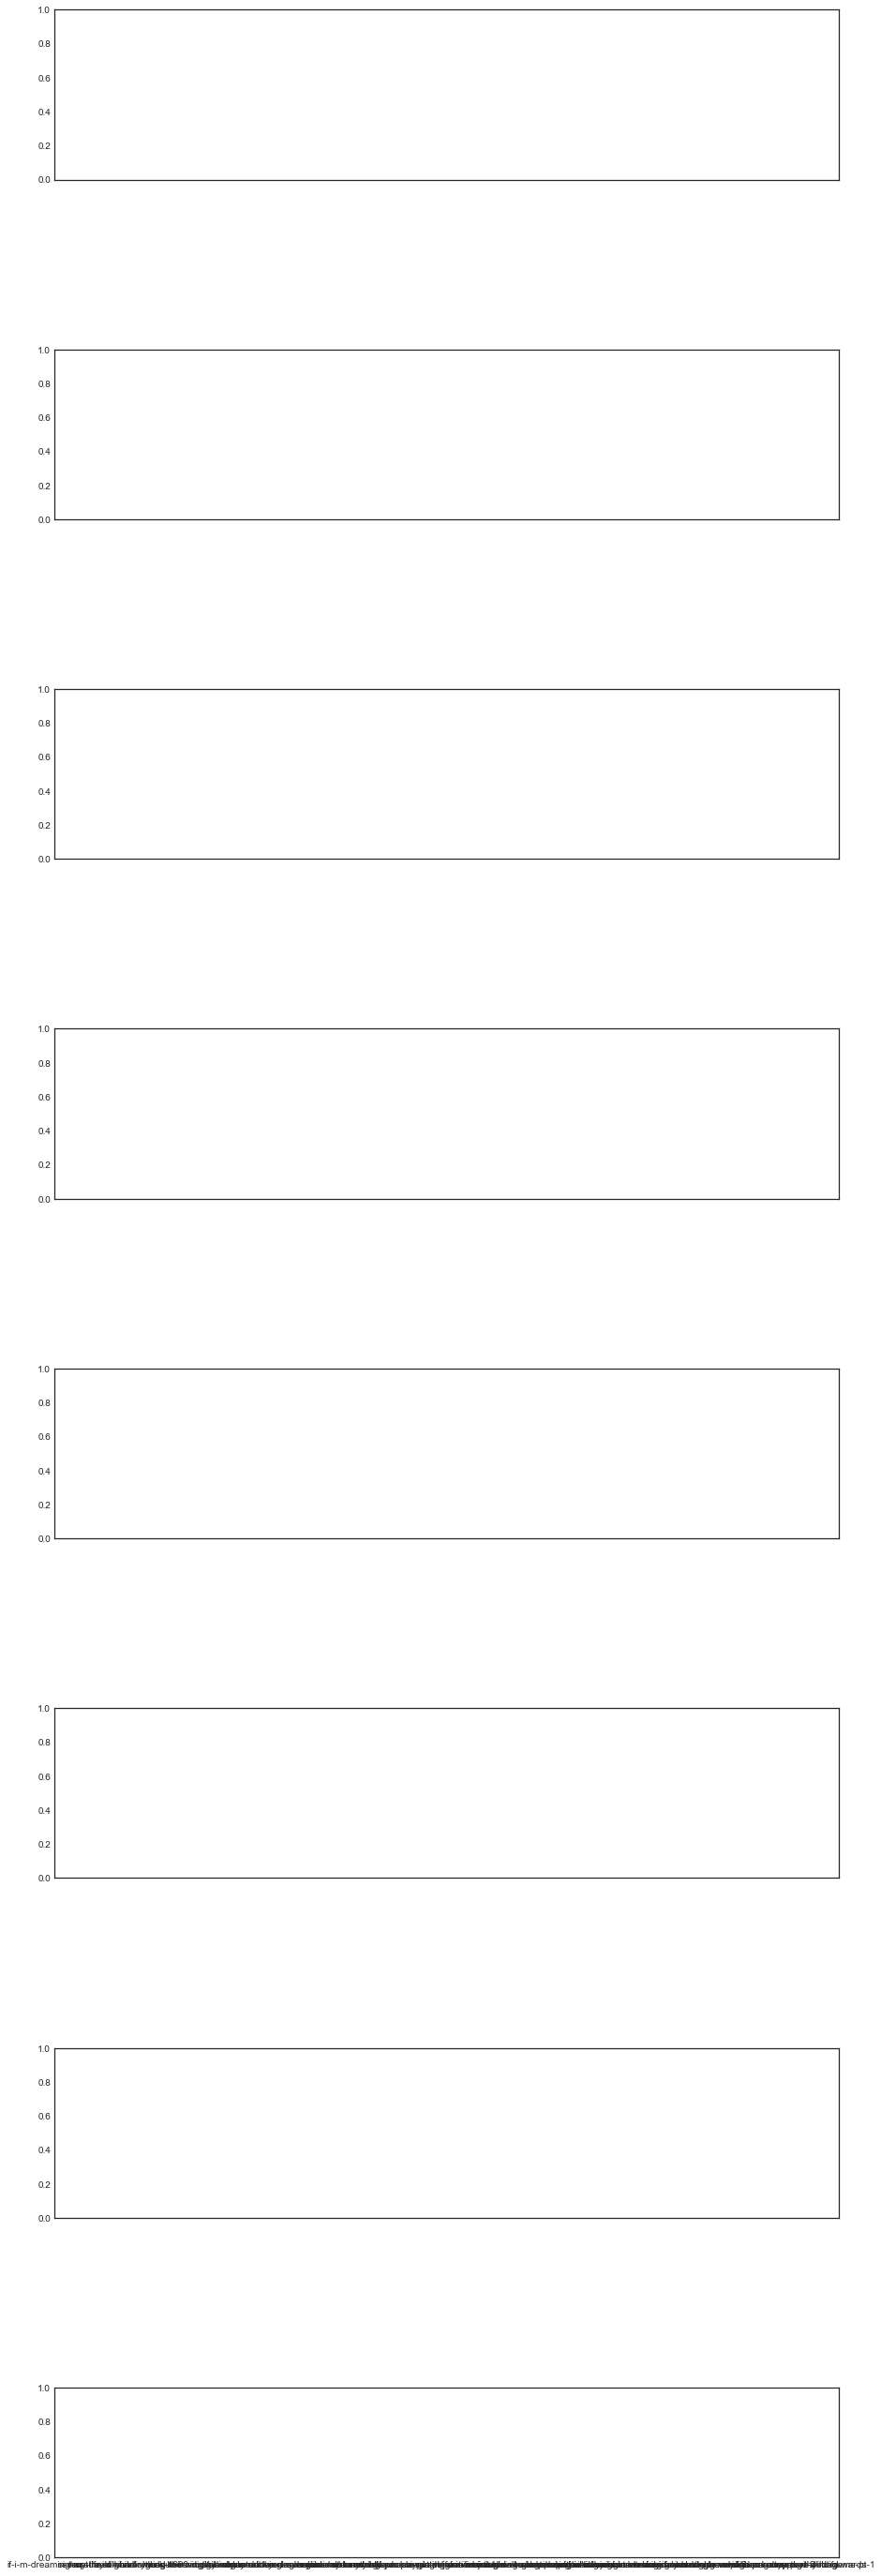

In [64]:
import math
import random

rows =lyrics_ldamodel.num_topics

fig, ax = plt.subplots(rows, 1, sharex='col', sharey='row')
fig.subplots_adjust(hspace=1, wspace=0.4) 
fig.set_figheight(50)
fig.set_figwidth(15)

plt.setp(ax, xticks=ind, xticklabels=bowie_song_titles)

min_rgb = 100
jump = 10
colors = []
for i in range(lyrics_ldamodel.num_topics):
    r = round((255 - (((i - 4) >= 0) * 40 * (i - 4)))/255, 3)
    g = round((102 + (((i - 3) >= 0) * 20 * (i - 3)))/255, 3)
    b = round((50 + (((i - 2) >= 0) * 10 * (i - 2)))/255, 3)
    rgb = [r,g,b]
    
    colors.append(sorted(rgb, key=lambda k: random.random()))

ind = range(len(bowie_song_titles))
which_topic = 0
for i in range(rows):
    if(which_topic == (lyrics_ldamodel.num_topics - (lyrics_ldamodel.num_topics % 2))):
        break
        
    print(which_topic)
      
    print(i)
    ax[i,0].bar(ind, doc2topics[:,which_topic])
        
    ax[i,0].title.set_text('Share of Topic #%d'%which_topic)

        
    which_topic += 1   

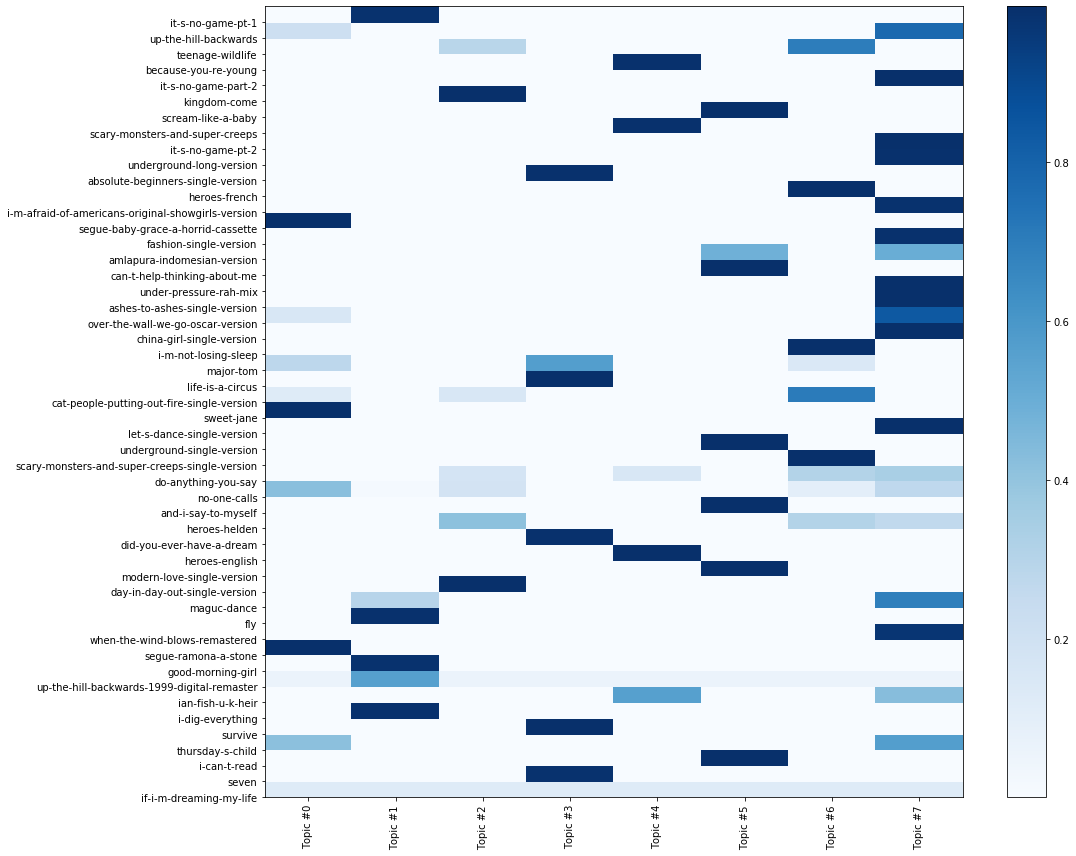

In [18]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics, norm=None, cmap='Blues')
plt.yticks(np.arange(doc2topics.shape[0]), bowie_song_titles)

plt.xticks(np.arange(doc2topics.shape[1])+0.5, ["Topic #"+str(n) for n in range(lyrics_ldamodel.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.show()

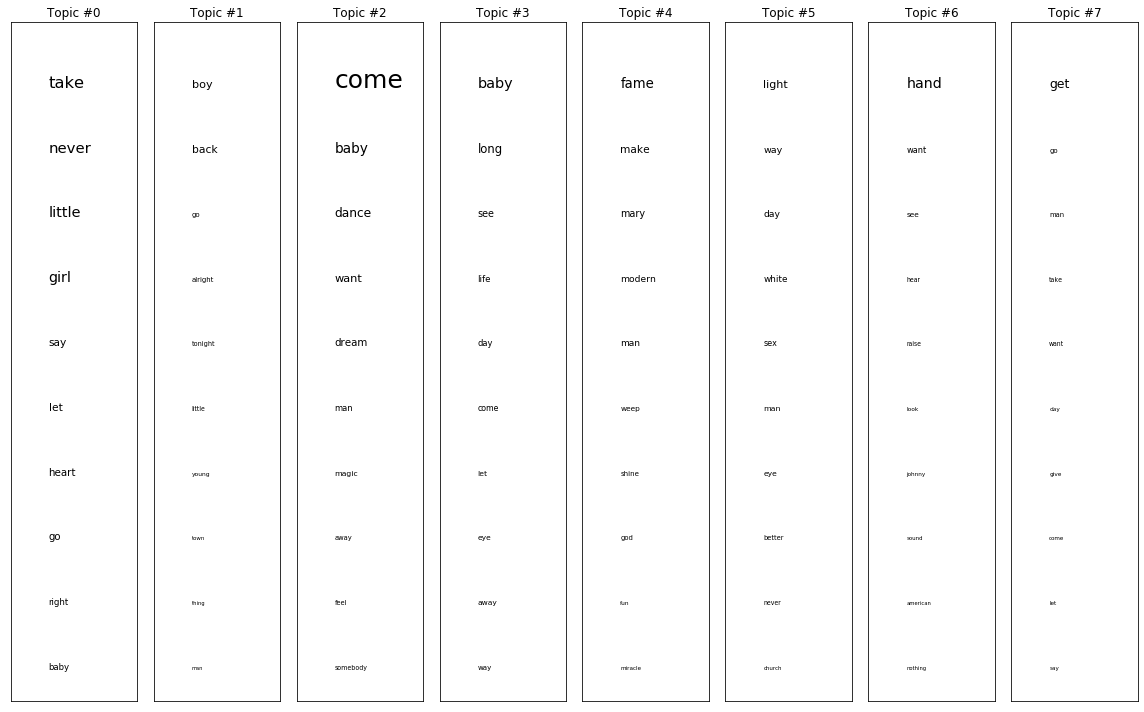

In [19]:
fig = plt.figure(figsize=(16, 10))

num_top_words = 10

topic2top_words = dict(lyrics_ldamodel.show_topics(formatted=False, num_words = num_top_words))
fontsize_base = 25 / max([w[0][1] for w in topic2top_words.values()]) # font size for word with largest share in corpus

for topic, words_shares in topic2top_words.items():
    plt.subplot(1, lyrics_ldamodel.num_topics, topic + 1)
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(topic))
    for i, (word, share) in enumerate(words_shares):
        plt.text(0.3, num_top_words-i-0.5, word, fontsize=fontsize_base*share)
        
plt.tight_layout()

In [20]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lyrics_ldamodel, texts=list_BOWlyrics[1:], dictionary=lyrics_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3436205427811895


In [21]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=lyrics_dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=lyrics_dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [44]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(lyrics_bow_corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(lyrics_bow_corpus, num_of_docs*0.75), 
               lyrics_bow_corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=lyrics_dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


  0%|          | 0/540 [00:00<?, ?it/s]

ValueError: Stop argument for islice() must be None or an integer: 0 <= x <= sys.maxsize.